In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid based SEPP method(s)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import open_cp.data
import open_cp.sources.sepp as source_sepp
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
import sepp.sepp_grid
import sepp.grid_nonparam

## Simulate some data

From the same model as we're fitting to.

In [3]:
rates = np.random.random(size=(10,10))
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
points = simulation.sample_to_randomised_grid(0, 365, grid_size=50)
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))
timed_points = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1),
    time_unit)

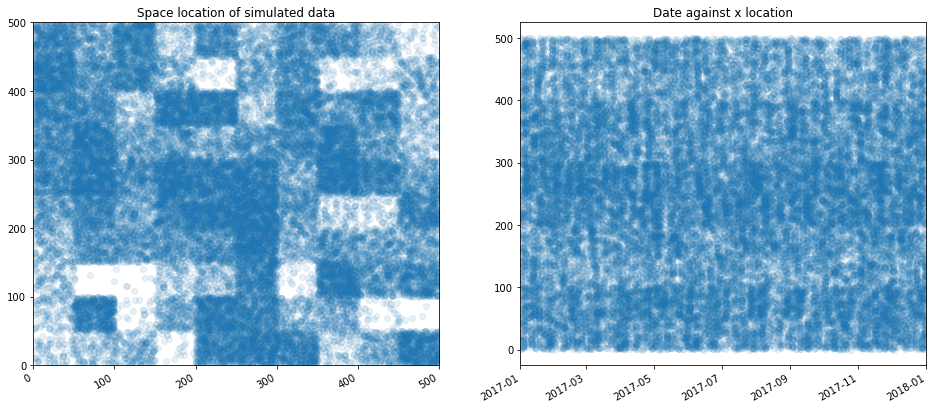

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.1)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,500], ylim=[0,500])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.1)
ax[1].set_xlim([datetime.datetime(2017,1,1), datetime.datetime(2018,1,1)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

## Train the model

The real values are $\theta=0.5, \omega=10$

In [5]:
mask = [[False] * 10 for _ in range(10)]
grid = open_cp.data.MaskedGrid(50, 50, 0, 0, mask)

In [6]:
trainer = sepp.sepp_grid.SEPPGridTrainer(grid)
trainer.data = timed_points

In [7]:
points = trainer.to_cells(datetime.datetime(2018,1,1))

In [8]:
mu = [[0.5] * 10] * 10
model = sepp.sepp_grid.ExpDecayModel(mu, 365, 0.2, 2)

In [9]:
for _ in range(10):
    opt = sepp.sepp_grid.ExpDecayOptFast(model, points)
    model = opt.optimised_model()
    print(model)

ExpDecayModel(T=365, theta=0.4323230464263127, omega=3.0065681831678592, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.4995006515772884, omega=4.27653214843144, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.5282066695296173, omega=5.554182148747411, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.5335274420906622, omega=6.67295458151024, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.5289630040733603, omega=7.579653529518552, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.5219211120405554, omega=8.282432541126756, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.5153418756305597, omega=8.811052916504403, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.5100445582671628, omega=9.20005974891843, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.5060460972113755, omega=9.481758540543144, mu size=(10, 10)
ExpDecayModel(T=365, theta=0.5031248014266189, omega=9.683390812526895, mu size=(10, 10)


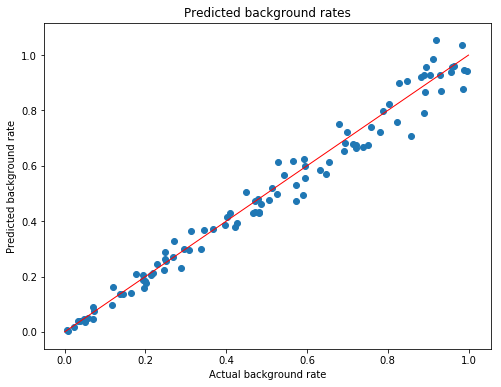

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(8,6))
ax.plot([0,1], [0,1], linewidth=1, color="r")
ax.scatter(rates.ravel(), model.mu.ravel())
#ax.set(xlim=[0,1], ylim=[0,np.max(predictor.mu)*1440*1.1])
ax.set(xlabel="Actual background rate", ylabel="Predicted background rate")
ax.set_title("Predicted background rates")
None

### With library

In [11]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = timed_points
model = trainer.train(datetime.datetime(2018,1,1))

In [12]:
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 0.1)
points = simulation.sample_to_randomised_grid(0, 365, grid_size=50)
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))

trainer1 = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer1.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)

In [13]:
model1 = trainer1.train(datetime.datetime(2018,1,1))
model2 = trainer1.train(datetime.datetime(2018,1,1), use_fast=False)

In [14]:
model, model1, model2

(ExpDecayModel(T=364.98074925925926, theta=0.5112169226365268, omega=9.123597466399298, mu size=(10, 10),
 ExpDecayModel(T=364.9714218171296, theta=0.22665663805809524, omega=0.6485398432920251, mu size=(10, 10),
 ExpDecayModel(T=364.9714218171296, theta=0.23307045483861763, omega=0.6268544282368601, mu size=(10, 10))

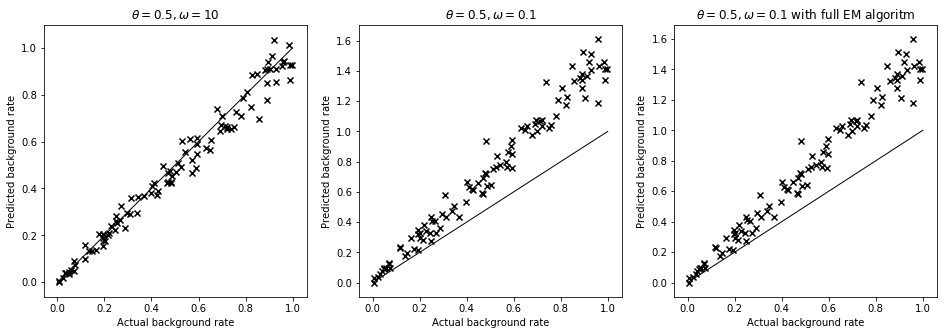

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

for ax, m in zip(axes, [model, model1, model2]):
    ax.plot([0,1], [0,1], linewidth=1, color="black")
    ax.scatter(rates.ravel(), m.mu.ravel(), color="black", marker="x")
    ax.set(xlabel="Actual background rate", ylabel="Predicted background rate")
axes[0].set_title("$\\theta=0.5, \omega=10$")
axes[1].set_title("$\\theta=0.5, \omega=0.1$")
axes[2].set_title("$\\theta=0.5, \omega=0.1$ with full EM algoritm")
None

In [16]:
fig.savefig("../simdata.pdf")

# With binned times

In [17]:
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
points = simulation.sample_to_randomised_grid(0, 365, grid_size=50)
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))

mask = [[False] * 10 for _ in range(10)]
grid = open_cp.data.MaskedGrid(50, 50, 0, 0, mask)

In [18]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
trainer.data = trainer.data.bin_timestamps(datetime.datetime(2017,1,1), datetime.timedelta(hours=1))
model = trainer.train(cutoff=datetime.datetime(2018,1,1), iterations=50, use_fast=True)
model

ExpDecayModel(T=365.0, theta=0.44814082476905576, omega=6.505705850907092, mu size=(10, 10)

In [19]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
trainer.data = trainer.data.bin_timestamps(datetime.datetime(2017,1,1), datetime.timedelta(hours=6))
model1 = trainer.train(cutoff=datetime.datetime(2018,1,1), iterations=50, use_fast=True)
model1

ExpDecayModel(T=365.0, theta=0.2237736472866703, omega=1.703358509747966, mu size=(10, 10)

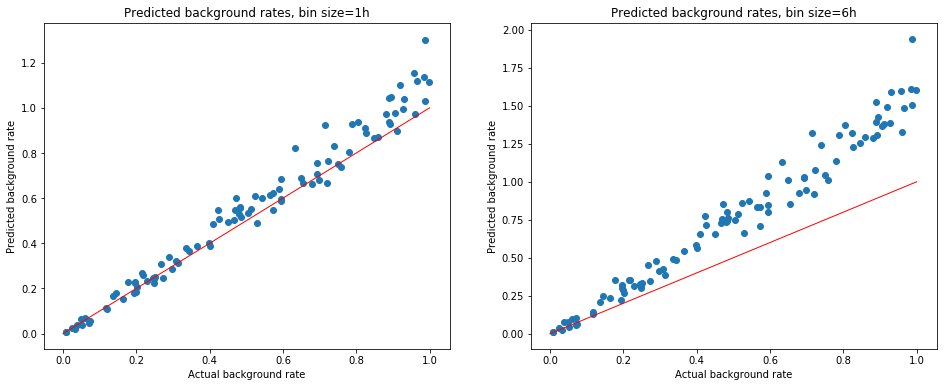

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

for ax, m in zip(axes, [model, model1]):
    ax.plot([0,1], [0,1], linewidth=1, color="r")
    ax.scatter(rates.ravel(), m.mu.ravel())
    #ax.set(xlim=[0,1], ylim=[0,np.max(predictor.mu)*1440*1.1])
    ax.set(xlabel="Actual background rate", ylabel="Predicted background rate")

axes[0].set_title("Predicted background rates, bin size=1h")
axes[1].set_title("Predicted background rates, bin size=6h")

# With histogram estimator

This originally caught a bug (so it was worth checking!)  We see a good match with artificial data.

In [21]:
def plot(model, bk_rate_scale=1):
    fig, axes = plt.subplots(ncols=2, figsize=(16,6))

    ax = axes[0]
    ax.plot([0,1], [0,1], linewidth=1, color="r")
    ax.scatter(rates.ravel(), model.mu.ravel() * bk_rate_scale)
    #ax.set(xlim=[0,1], ylim=[0,np.max(predictor.mu)*1440*1.1])
    ax.set(xlabel="Actual background rate", ylabel="Predicted background rate")
    ax.set_title("Predicted background rates")

    ax = axes[1]
    x = np.arange(20) * model.bandwidth
    ax.plot(x, model.alpha[:len(x)])
    y = np.exp(-x*10) * (1 - np.exp(-10*model.bandwidth))
    ax.plot(x, y)
    ax.set(xlabel="Days", title="Trigger")
    
    return fig

In [22]:
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
points = simulation.sample_to_randomised_grid(0, 365, grid_size=50)
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))

mask = [[False] * 10 for _ in range(10)]
grid = open_cp.data.MaskedGrid(50, 50, 0, 0, mask)

ExpDecayModel(T=364.99150310185183, theta=0.5153594852534191, bandwidth=0.1, alpha=[ 0.62952117  0.21937495  0.0802917   0.02585919  0.01160542  0.00403282  0.00231138  0.00214073  0.00175434  0.00113082 ... ]

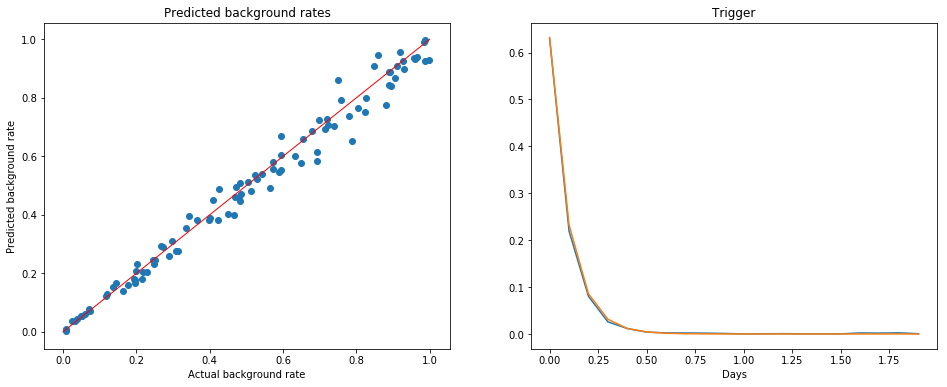

In [23]:
trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=0.1)
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
model = trainer.train(cutoff=datetime.datetime(2018,1,1), iterations=50, use_fast=True)
fig = plot(model)
model

ExpDecayModel(T=364.99150310185183, theta=0.5049262292572381, bandwidth=0.5, alpha=[  9.81519394e-01   9.53790060e-04   2.27492353e-03   7.08716822e-03   2.14398844e-03   1.01642179e-03   1.27016729e-03   1.65151867e-03   8.72541861e-04   2.91846039e-04 ... ]

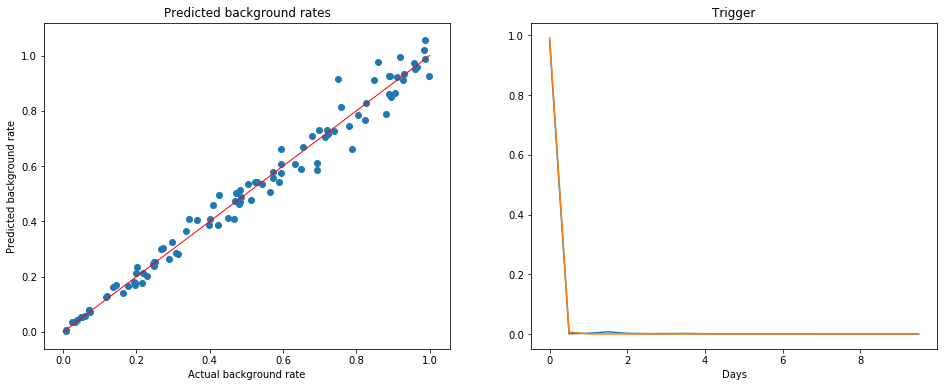

In [24]:
trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=0.5)
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
model = trainer.train(cutoff=datetime.datetime(2018,1,1), iterations=50, use_fast=True)
fig = plot(model)
model

ExpDecayModel(T=364.99150310185183, theta=0.48945637474875736, bandwidth=1, alpha=[  9.88506462e-01   2.33900964e-03   3.82136268e-03   2.90583543e-03   1.26225116e-03   4.85301456e-04   6.03867160e-04   5.78713333e-05   5.00240218e-06   8.62989525e-06 ... ]

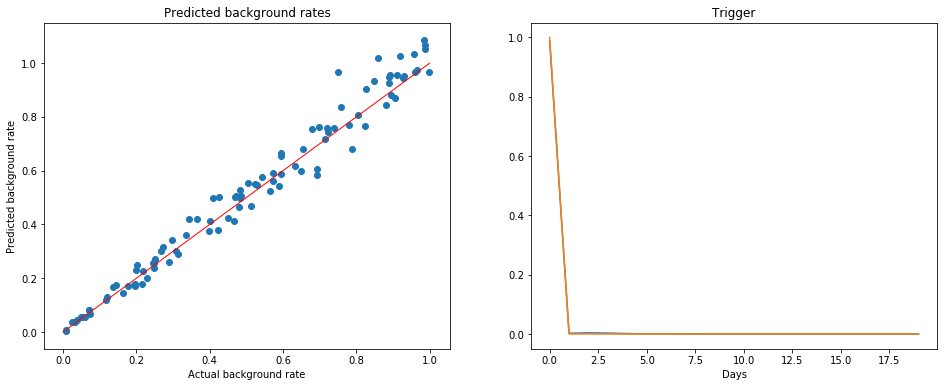

In [25]:
trainer = sepp.grid_nonparam.NonParamTrainer(grid, bandwidth=1)
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
model = trainer.train(cutoff=datetime.datetime(2018,1,1), iterations=50, use_fast=True)
fig = plot(model)
model

ExpDecayModel(T=364.99150310185183, theta=0.48945637474875736, bandwidth=1, alpha=[  9.88506462e-01   2.33900964e-03   3.82136268e-03   2.90583543e-03   1.26225116e-03   4.85301456e-04   6.03867160e-04   5.78713333e-05   5.00240218e-06   8.62989525e-06 ... ]

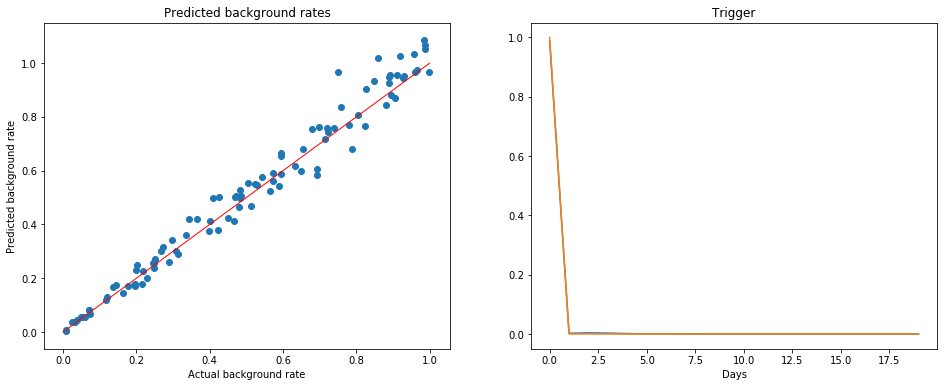

In [26]:
fig = plot(model)
model

# With KDE estimator

Uses a load of memory, and gets very slow, so we use a smaller grid and a smaller time range.

In [27]:
rates = np.random.random(size=(2,2))
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
length = 50
points = simulation.sample_to_randomised_grid(0, length, grid_size=50)
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=365 / length))

mask = [[False] * 2 for _ in range(2)]
grid = open_cp.data.MaskedGrid(50, 50, 0, 0, mask)

In [28]:
def plot(length, model):
    fig, axes = plt.subplots(ncols=2, figsize=(16,6))

    ax = axes[0]
    ax.plot([0,1], [0,1], linewidth=1, color="r")
    ax.scatter(rates.ravel(), model.mu.ravel() * 365 / length)
    #ax.set(xlim=[0,1], ylim=[0,np.max(predictor.mu)*1440*1.1])
    ax.set(xlabel="Actual background rate", ylabel="Predicted background rate")
    ax.set_title("Predicted background rates")

    ax = axes[1]
    x = np.linspace(0, 10, 100)
    ax.plot(x, model.trigger_func(x) * model.theta)
    y = 0.5 * 10 * np.exp(-10 * x)
    ax.plot(x, y)
    ax.set(xlabel="Days", title="Trigger", ylim=[0,1])
    
    return fig

In [29]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(1))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
model

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.43958606742147416, f=<open_cp.kernels.Reflect1D object at 0x00000238DE1BD898>

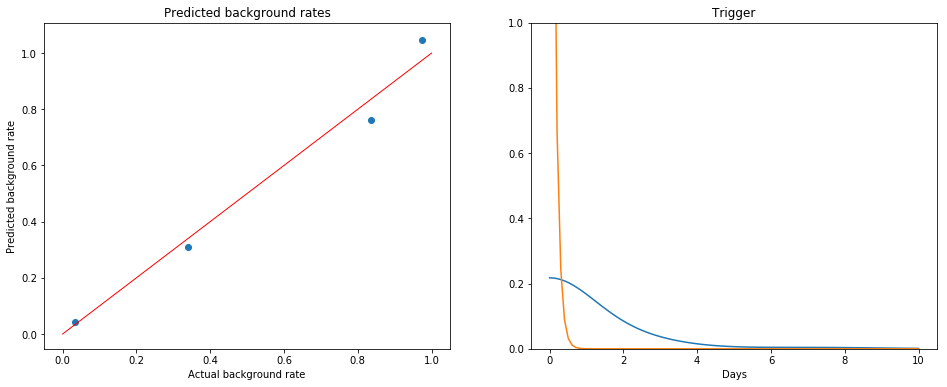

In [30]:
fig = plot(length, model)

In [31]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(0.2))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
model

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.45220601426053125, f=<open_cp.kernels.Reflect1D object at 0x00000238E220CBE0>

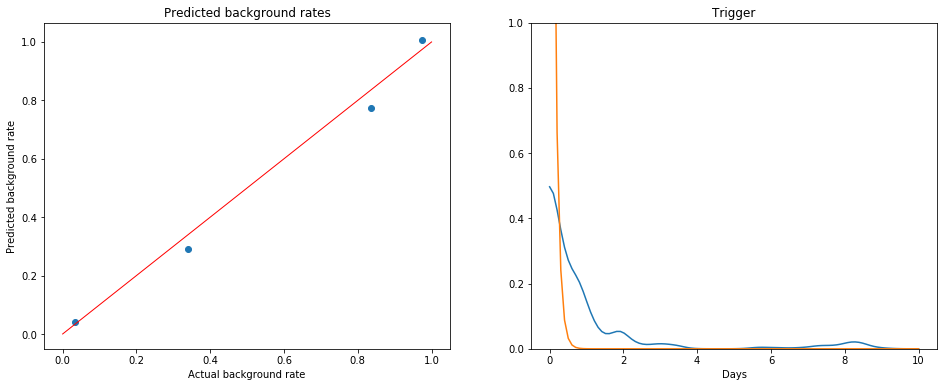

In [32]:
fig = plot(length, model)

In [33]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(0.1))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
model

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.5494602451819701, f=<open_cp.kernels.Reflect1D object at 0x00000238DE33CA90>

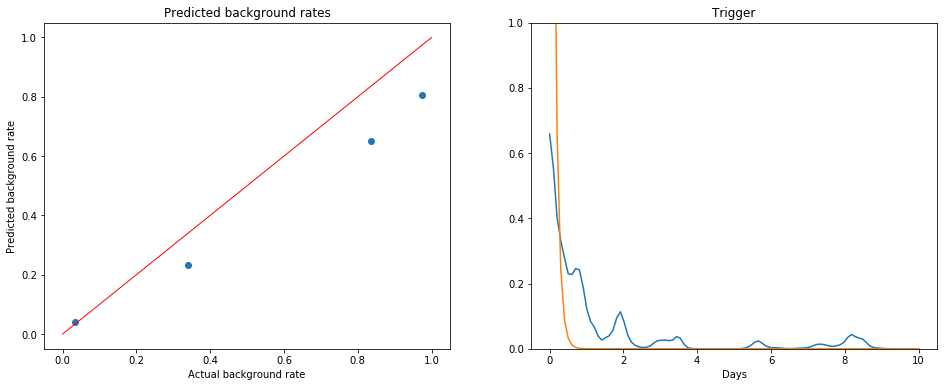

In [34]:
fig = plot(length, model)

In [35]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderFixedBandwidth(0.01))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
model

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.9661053611144926, f=<open_cp.kernels.Reflect1D object at 0x00000238E2224278>

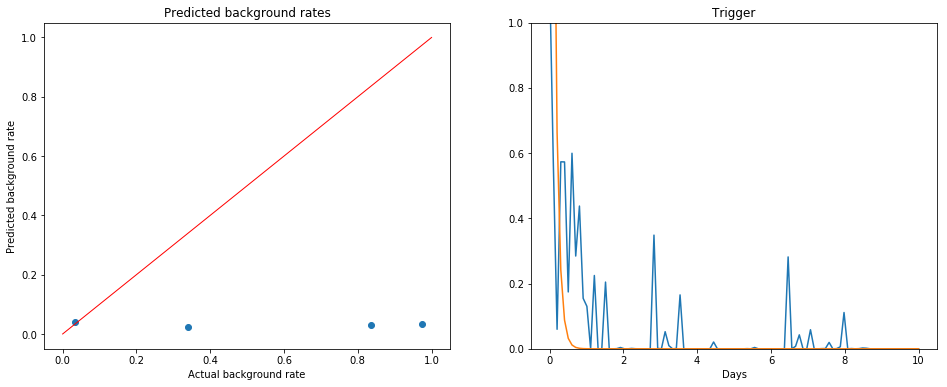

In [36]:
fig = plot(length, model)

In [37]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(3))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
model

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.9614004540246168, f=<open_cp.kernels.Reflect1D object at 0x00000238DE326A20>

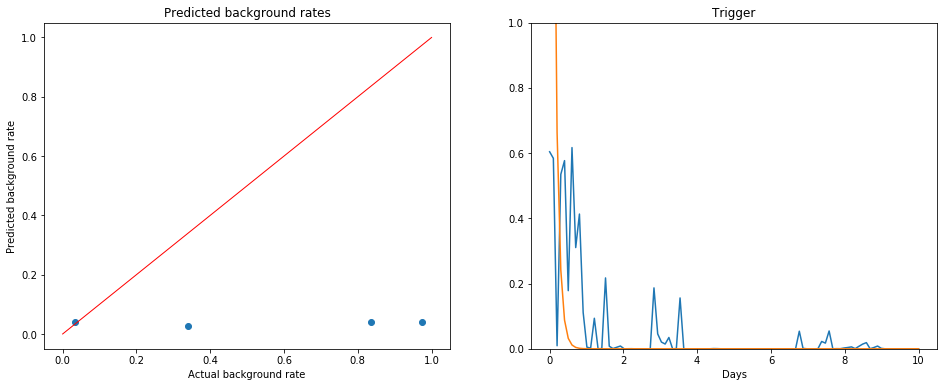

In [38]:
fig = plot(length, model)

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.8366989689642473, f=<open_cp.kernels.Reflect1D object at 0x00000238E22426D8>

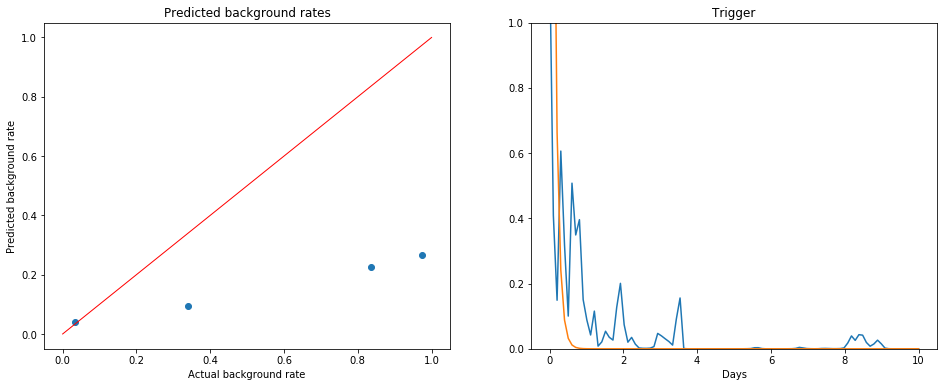

In [39]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(6))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
plot(length, model)
model

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.6341304116191646, f=<open_cp.kernels.Reflect1D object at 0x00000238DDE7DEB8>

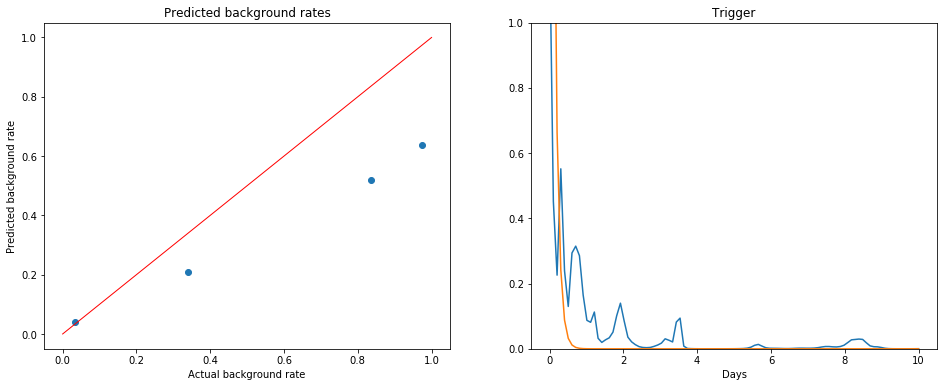

In [40]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(10))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
plot(length, model)
model

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.446152593943802, f=<open_cp.kernels.Reflect1D object at 0x00000238DDCF77F0>

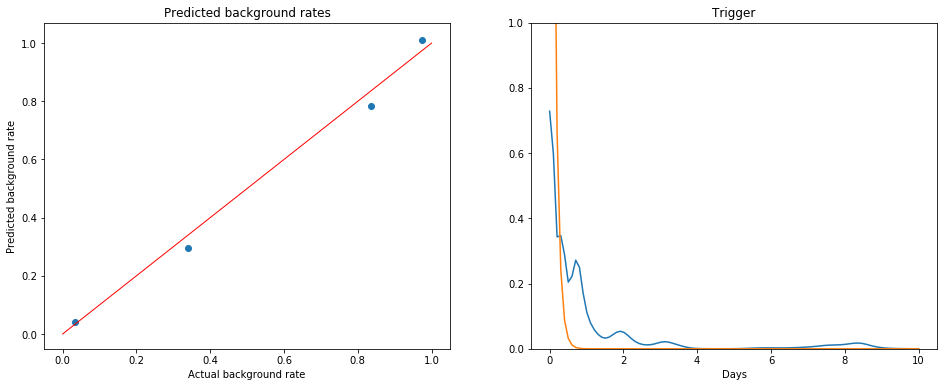

In [41]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(20))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
plot(length, model)
model

(numpy.datetime64('2017-01-13T08:13:47.030'), numpy.datetime64('2017-12-29T17:38:47.677'))


ExpDecayModel(T=352.65709456018516, theta=0.4077538860284717, f=<open_cp.kernels.Reflect1D object at 0x00000238DE1C50B8>

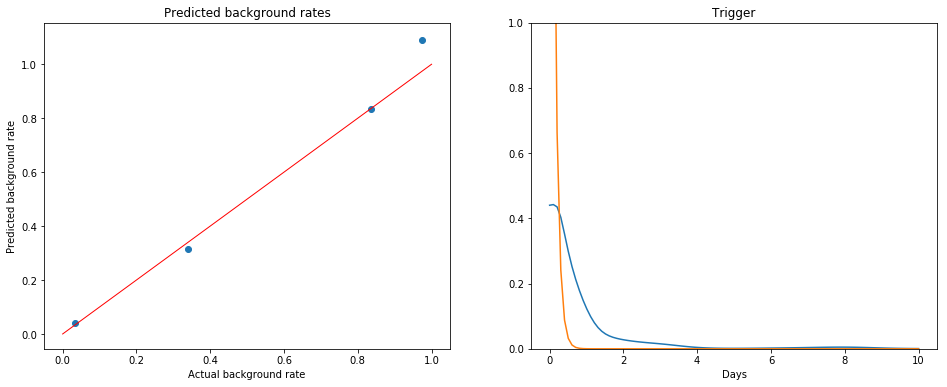

In [42]:
trainer = sepp.grid_nonparam.KDETrainer(grid, sepp.grid_nonparam.KDEProviderKthNearestNeighbour(50))
trainer.data = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1), time_unit)
print(trainer.data.time_range)
model = trainer.train(datetime.datetime(2018,1,1), iterations=50)
plot(length, model)
model